https://www.kaggle.com/code/ashishpatel26/lung-opacity-classification-using-densenet-121

In [ ]:
https://www.kaggle.com/code/kretes/rpn-mask-r-cnn-regions-exploration-on-rsna-data

https://www.kaggle.com/code/nazeernazeer/pneumonia-capstone-proj

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [30]:
# params we will probably want to do some hyperparameter optimization later
BASE_MODEL= 'DenseNet121'
IMG_SIZE = (512, 512) # [(224, 224), (384, 384), (512, 512), (640, 640)]
BATCH_SIZE = 24 # [1, 8, 16, 24]
DENSE_COUNT = 128 # [32, 64, 128, 256]
DROPOUT = 0.5 # [0, 0.25, 0.5]
LEARN_RATE = 1e-4 # [1e-4, 1e-3, 4e-3]
TRAIN_SAMPLES = 6000 # [3000, 6000, 15000]
TEST_SAMPLES = 600
USE_ATTN = False # [True, False]

In [3]:
image_bbox_df = pd.read_csv('image_bbox_full.csv')
image_bbox_df['path'] = image_bbox_df['path'].map(lambda x: 
                                                  x.replace('input', 
                                                            'rsna-pneumonia'))
print(image_bbox_df.shape[0], 'images')
image_bbox_df.sample(3)

30227 images


,patientId,x,y,width,height,Target,class,boxes,path
3444,308eab64-517b-46f1-8865-d9566b087bff,695.0,558.0,172.0,105.0,1,Lung Opacity,3,../rsna-pneumonia/stage_2_train_images/308eab6...
18694,a75649b5-f044-4b85-86e7-91e6c6051826,NaN,NaN,NaN,NaN,0,Normal,1,../rsna-pneumonia/stage_2_train_images/a75649b...
3948,342bd0cf-b337-40e9-8512-eb170292e2f2,317.0,519.0,121.0,127.0,1,Lung Opacity,1,../rsna-pneumonia/stage_2_train_images/342bd0c...


In [4]:
# get the labels in the right format
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
class_enc = LabelEncoder()
image_bbox_df['class_idx'] = class_enc.fit_transform(image_bbox_df['class'])
oh_enc = OneHotEncoder(sparse=False)
image_bbox_df['class_vec'] = oh_enc.fit_transform(
    image_bbox_df['class_idx'].values.reshape(-1, 1)).tolist() 
image_bbox_df.sample(3)

,patientId,x,y,width,height,Target,class,boxes,path,class_idx,class_vec
27726,ec3697bd-184e-44ba-9688-ff8d5fbf9bbc,NaN,NaN,NaN,NaN,0,Normal,1,../rsna-pneumonia/stage_2_train_images/ec3697b...,2,"[0.0, 0.0, 1.0]"
18645,a6fc3abd-e573-4412-991d-65f6bf3e5b17,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,../rsna-pneumonia/stage_2_train_images/a6fc3ab...,1,"[0.0, 1.0, 0.0]"
14218,83e0c51c-af5b-457e-849b-bfdf083782ed,NaN,NaN,NaN,NaN,0,Normal,1,../rsna-pneumonia/stage_2_train_images/83e0c51...,2,"[0.0, 0.0, 1.0]"


In [7]:
from sklearn.model_selection import train_test_split
image_df = image_bbox_df.groupby('patientId').apply(lambda x: x.sample(1))
image_df = image_df[:20000]
raw_train_df, valid_df = train_test_split(image_df, test_size=0.25, random_state=200,
                                    stratify=image_df['class'])
print(raw_train_df.shape, 'training data')
print(valid_df.shape, 'validation data')

(15000, 11) training data
(5000, 11) validation data


6000 new training size


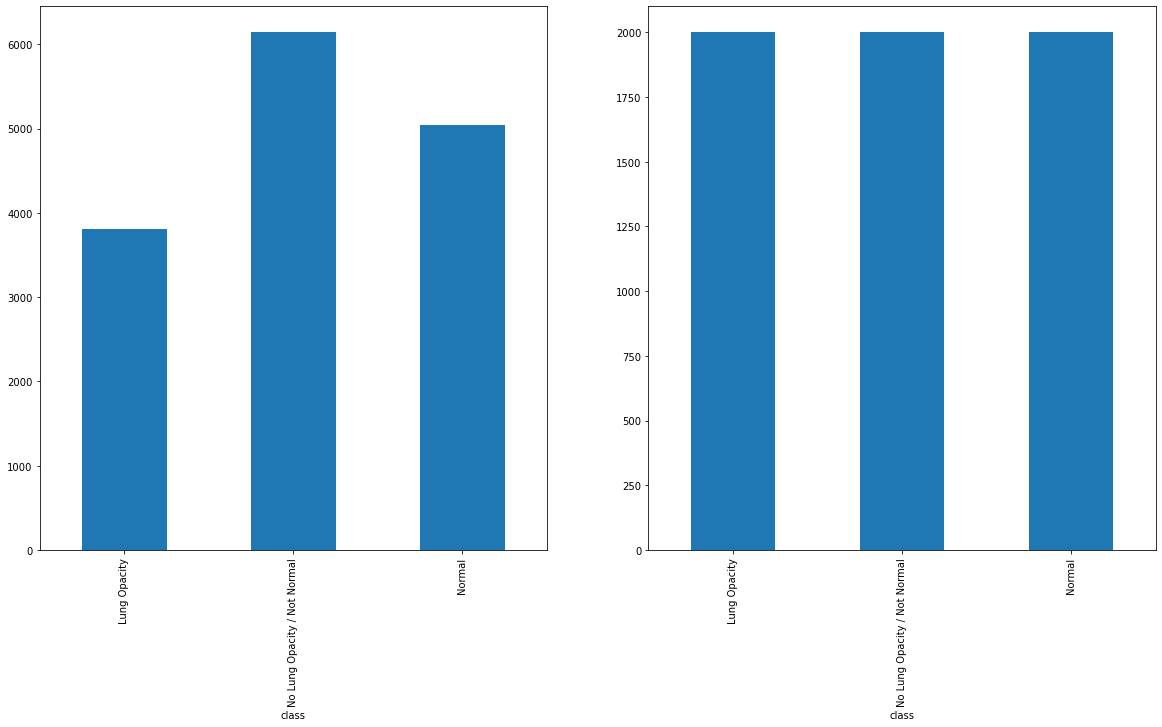

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
raw_train_df.groupby('class').size().plot.bar(ax=ax1)
train_df = raw_train_df.groupby('class').\
    apply(lambda x: x.sample(TRAIN_SAMPLES//3)).\
    reset_index(drop=True)
train_df.groupby('class').size().plot.bar(ax=ax2) 
print(train_df.shape[0], 'new training size')

In [9]:
import keras.preprocessing.image as KPImage
from PIL import Image
import pydicom
def read_dicom_image(in_path):
    img_arr = pydicom.read_file(in_path).pixel_array
    return img_arr/img_arr.max()
    
class medical_pil():
    @staticmethod
    def open(in_path):
        if '.dcm' in in_path:
            c_slice = read_dicom_image(in_path)
            int_slice =  (255*c_slice).clip(0, 255).astype(np.uint8) # 8bit images are more friendly
            return Image.fromarray(int_slice)
        else:
            return Image.open(in_path)
    fromarray = Image.fromarray
KPImage.pil_image = medical_pil

Using TensorFlow backend.
c:\Users\82106\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\Users\82106\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\Users\82106\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\Users\82106\anaconda3\envs\te

In [11]:
import os
import csv
import random
import pydicom
import numpy as np
import pandas as pd
from skimage import measure
from skimage.transform import resize

import tensorflow as tf
from tensorflow import keras

from matplotlib import pyplot as plt

In [60]:
try:
    # keras 2.2
    from keras_preprocessing.image import ImageDataGenerator
except:
    from keras.preprocessing.image import ImageDataGenerator
if BASE_MODEL=='VGG16':
    from keras.applications.vgg16 import VGG16 as PTModel, preprocess_input
elif BASE_MODEL=='RESNET52':
    from keras.applications.resnet50 import ResNet50 as PTModel, preprocess_input
elif BASE_MODEL=='InceptionV3':
    from keras.applications.inception_v3 import InceptionV3 as PTModel, preprocess_input
elif BASE_MODEL=='Xception':
    from keras.applications.xception import Xception as PTModel, preprocess_input
elif BASE_MODEL=='DenseNet169': 
    keras.applications.densenet.DenseNet169
elif BASE_MODEL=='DenseNet121':
    keras.applications.densenet.DenseNet121
# elif BASE_MODEL=='DenseNet169': 
#     keras.applications.densenet.DenseNet169 as PTModel, preprocess_input
# elif BASE_MODEL=='DenseNet121':
#     keras.applications.densenet.DenseNet121 as PTModel, preprocess_input
else:
    raise ValueError('Unknown model: {}'.format(BASE_MODEL))

In [21]:
from keras.applications.imagenet_utils import preprocess_input

In [22]:
img_gen_args = dict(samplewise_center=False, 
                              samplewise_std_normalization=False, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range = 0.05, 
                              width_shift_range = 0.02, 
                              rotation_range = 3, 
                              shear_range = 0.01,
                              fill_mode = 'nearest',
                              zoom_range = 0.05,
                               preprocessing_function=preprocess_input)
img_gen = ImageDataGenerator(**img_gen_args)

In [41]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, seed = None, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    print('## Ignore next message from keras, values are replaced anyways: seed: {}'.format(seed))
    df_gen = img_data_gen.flow_from_directory(base_dir, 
                                     class_mode = 'sparse',
                                              seed = seed,
                                    **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values,0)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = '' # since we have the full path
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen

In [28]:
image_bbox_df['path']

0        ../rsna-pneumonia/stage_2_train_images/0004cfa...
1        ../rsna-pneumonia/stage_2_train_images/000924c...
2        ../rsna-pneumonia/stage_2_train_images/000db69...
3        ../rsna-pneumonia/stage_2_train_images/000db69...
4        ../rsna-pneumonia/stage_2_train_images/000fe35...
                               ...                        
30222    ../rsna-pneumonia/stage_2_train_images/fffb239...
30223    ../rsna-pneumonia/stage_2_train_images/fffba05...
30224    ../rsna-pneumonia/stage_2_train_images/fffc95b...
30225    ../rsna-pneumonia/stage_2_train_images/fffcff1...
30226    ../rsna-pneumonia/stage_2_train_images/fffec09...
Name: path, Length: 30227, dtype: object

In [38]:
train_df['path']

0       ../rsna-pneumonia/stage_2_train_images/09b2d54...
1       ../rsna-pneumonia/stage_2_train_images/c1ffc79...
2       ../rsna-pneumonia/stage_2_train_images/3a146de...
3       ../rsna-pneumonia/stage_2_train_images/8f0e79e...
4       ../rsna-pneumonia/stage_2_train_images/b1a8c34...
                              ...                        
5995    ../rsna-pneumonia/stage_2_train_images/58119b6...
5996    ../rsna-pneumonia/stage_2_train_images/7fe0839...
5997    ../rsna-pneumonia/stage_2_train_images/574f1f6...
5998    ../rsna-pneumonia/stage_2_train_images/901950a...
5999    ../rsna-pneumonia/stage_2_train_images/7f1e4c1...
Name: path, Length: 6000, dtype: object

In [39]:
train_df['class_vec']

0       [1.0, 0.0, 0.0]
1       [1.0, 0.0, 0.0]
2       [1.0, 0.0, 0.0]
3       [1.0, 0.0, 0.0]
4       [1.0, 0.0, 0.0]
             ...       
5995    [0.0, 0.0, 1.0]
5996    [0.0, 0.0, 1.0]
5997    [0.0, 0.0, 1.0]
5998    [0.0, 0.0, 1.0]
5999    [0.0, 0.0, 1.0]
Name: class_vec, Length: 6000, dtype: object

In [42]:
train_gen = flow_from_dataframe(img_gen, train_df, 
                             path_col = 'path',
                            y_col = 'class_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = BATCH_SIZE)

KeyError: 'path_col'

In [43]:
# load and shuffle filenames
folder = 'rsna-pneumonia/stage_2_train_images'
filenames = os.listdir(folder)
random.shuffle(filenames)
# split into train and validation filenames
n_valid_samples = 2560
train_filenames = filenames[n_valid_samples:20000]
valid_filenames = filenames[:n_valid_samples]
print('n train samples', len(train_filenames))
print('n valid samples', len(valid_filenames))
n_train_samples = len(filenames) - n_valid_samples

n train samples 17440
n valid samples 2560


In [44]:
# empty dictionary
pneumonia_locations = {}
# load table
with open(os.path.join('rsna-pneumonia/stage_2_train_labels.csv'), mode='r') as infile:
    # open reader
    reader = csv.reader(infile)
    # skip header
    next(reader, None)
    # loop through rows
    for rows in reader:
        # retrieve information
        filename = rows[0]
        location = rows[1:5]
        pneumonia = rows[5]
        # if row contains pneumonia add label to dictionary
        # which contains a list of pneumonia locations per filename
        if pneumonia == '1':
            # convert string to float to int
            location = [int(float(i)) for i in location]
            # save pneumonia location in dictionary
            if filename in pneumonia_locations:
                pneumonia_locations[filename].append(location)
            else:
                pneumonia_locations[filename] = [location]

In [45]:
class generator(keras.utils.Sequence):
    
    def __init__(self, folder, filenames, pneumonia_locations=None, batch_size=32, image_size=256, shuffle=True, augment=False, predict=False):
        self.folder = folder
        self.filenames = filenames
        self.pneumonia_locations = pneumonia_locations
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.predict = predict
        self.on_epoch_end()
        
    def __load__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # create empty mask
        msk = np.zeros(img.shape)
        # get filename without extension
        filename = filename.split('.')[0]
        # if image contains pneumonia
        if filename in pneumonia_locations:
            # loop through pneumonia
            for location in pneumonia_locations[filename]:
                # add 1's at the location of the pneumonia
                x, y, w, h = location
                msk[y:y+h, x:x+w] = 1
        # if augment then horizontal flip half the time
        if self.augment and random.random() > 0.5:
            img = np.fliplr(img)
            msk = np.fliplr(msk)
        # resize both image and mask
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        msk = resize(msk, (self.image_size, self.image_size), mode='reflect') > 0.45
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        msk = np.expand_dims(msk, -1)
        return img, msk

    def __loadpredict__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # resize image
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        return img
        
    def __getitem__(self, index):
        # select batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
        # predict mode: return images and filenames
        if self.predict:
            # load files
            imgs = [self.__loadpredict__(filename) for filename in filenames]
            # create numpy batch
            imgs = np.array(imgs)
            return imgs, filenames
        # train mode: return images and masks
        else:
            # load files
            items = [self.__load__(filename) for filename in filenames]
            # unzip images and masks
            imgs, msks = zip(*items)
            # create numpy batch
            imgs = np.array(imgs)
            msks = np.array(msks)
            return imgs, msks
        
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)
        
    def __len__(self):
        if self.predict:
            # return everything
            return int(np.ceil(len(self.filenames) / self.batch_size))
        else:
            # return full batches only
            return int(len(self.filenames) / self.batch_size)

In [46]:
# create train and validation generators
folder = 'rsna-pneumonia/stage_2_train_images'
train_gen = generator(folder, train_filenames, pneumonia_locations, batch_size=16, image_size=256, shuffle=True, augment=True, predict=False)
valid_gen = generator(folder, valid_filenames, pneumonia_locations, batch_size=16, image_size=256, shuffle=False, predict=False)

In [49]:
print(len(train_gen))

1090


In [56]:
# t_x, t_y = train_test_split(train_gen, test_size=0.25, random_state=124)
t_x = train_gen[:800]
t_y = train_gen[800:]
print(t_x.shape)

(800, 11)


In [61]:
base_pretrained_model = PTModel(input_shape =  t_x.shape[1:], 
                              include_top = False, weights = 'imagenet')
base_pretrained_model.trainable = False

NameError: name 'PTModel' is not defined

In [62]:
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D, Lambda, AvgPool2D
from keras.models import Model
from keras.optimizers import Adam
pt_features = Input(base_pretrained_model.get_output_shape_at(0)[1:], name = 'feature_input')
pt_depth = base_pretrained_model.get_output_shape_at(0)[-1]
from keras.layers import BatchNormalization
bn_features = BatchNormalization()(pt_features)
gap = GlobalAveragePooling2D()(bn_features)

gap_dr = Dropout(DROPOUT)(gap)
dr_steps = Dropout(DROPOUT)(Dense(DENSE_COUNT, activation = 'elu')(gap_dr))
out_layer = Dense(t_y.shape[1], activation = 'softmax')(dr_steps)

attn_model = Model(inputs = [pt_features], 
                   outputs = [out_layer], name = 'trained_model')

attn_model.summary()

NameError: name 'base_pretrained_model' is not defined